In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import pylab as py
import os
import random

# SETTINGS
main_dir = os.getcwd() + r'\\'
data_name = main_dir + 'match_vectors_no_label.csv'

FEATURE_LABEL = [
    'h_roster_rating', 'h_gk_rating', 'h_def_rating', 'h_mid_rating', 'h_off_rating',
    'a_roster_rating', 'a_gk_rating', 'a_def_rating', 'a_mid_rating', 'a_off_rating', 'label'
]
FIGURE_SIZE = (8, 10)
DPI = 150


In [2]:
def generate_igor(x_label, x_data, y_label, y_data, plot_save):
    if not x_label and not x_data and not y_label and not y_data:
        return
    igor_save = plot_save[:-3] + 'itx'
    with open(igor_save, 'w') as f:
        for L in [x_label, y_label]:
            for i in range(len(L)):
                L[i] = '\'' + L[i] + '\''
        s_return = 'IGOR\rWAVES/D\t' + '\t'.join(x_label + y_label) + '\rBEGIN\r'
        if not isinstance(x_data, list): x_data = np.ndarray.tolist(x_data)
        if not isinstance(y_data, list): y_data = np.ndarray.tolist(y_data)
        L_data = x_data + y_data
        max_i = max(len(d) for d in L_data)
        for i in range(max_i):
            row = '\t'.join(str(d[i]) if len(d) > i else 'NAN' for d in L_data)
            s_return += row + '\r'
        s_return += 'END'
        f.write(s_return)


In [3]:
def add_x0(x):
    result = np.zeros((x.shape[0], x.shape[1] + 1))
    result[:, 0] = 1
    result[:, 1:] = x
    return result

def define_xy(data, L_i, ratio=0.8, add_zero=True):
    x = add_x0(data[:, L_i]) if add_zero else data[:, L_i]
    y = data[:, -1]
    split_idx = int(len(y) * ratio)
    return x[:split_idx], y[:split_idx], x[split_idx:], y[split_idx:]

def arrange_data(file_name, L_i):
    data = np.genfromtxt(file_name, delimiter=',')
    x_train, y_train, x_test, y_test = define_xy(data, L_i, 0.8, False)
    x_train_lr, y_train_lr = add_x0(x_train[y_train != 0]), y_train[y_train != 0]
    x_test_lr, y_test_lr = add_x0(x_test[y_test != 0]), y_test[y_test != 0]
    x_train_g, y_train_g = x_train[y_train == 0], y_train[y_train == 0]
    x_test_g, y_test_g = x_test[y_test == 0], y_test[y_test == 0]
    return x_train, y_train, x_test, y_test, x_train_lr, y_train_lr, x_test_lr, y_test_lr, x_train_g, y_train_g, x_test_g, y_test_g


In [4]:
def Gaussian(X, mu, sigma, matrix=True):
    if matrix:
        vals = []
        inv_sigma = np.linalg.inv(sigma)
        det_sigma = np.linalg.det(sigma)
        coef = 1 / (((2 * np.pi) ** (len(mu) / 2)) * (det_sigma ** 0.5))
        for x in X:
            vals.append(coef * np.exp(-0.5 * (x - mu).dot(inv_sigma).dot(x - mu)))
        return vals
    else:
        inv_sigma = np.linalg.inv(sigma)
        det_sigma = np.linalg.det(sigma)
        coef = 1 / (((2 * np.pi) ** (len(mu) / 2)) * (det_sigma ** 0.5))
        return coef * np.exp(-0.5 * (X - mu).dot(inv_sigma).dot(X - mu))

def get_mu_sigma_phi(x_train, y_train):
    def stats(label):
        mask = y_train == label
        return x_train[mask].mean(0), np.cov(x_train[mask], rowvar=0), (y_train == label).mean()
    mu_w, s_w, p_w = stats(1)
    mu_d, s_d, p_d = stats(0)
    mu_l, s_l, p_l = stats(-1)
    return [mu_w, mu_d, mu_l], [s_w, s_d, s_l], [p_w, p_d, p_l]

def w_GDA(x_i, L_phi, L_mu, L_sigma):
    probs = [Gaussian(x_i, L_mu[j], L_sigma[j], matrix=False) * L_phi[j] for j in range(len(L_phi))]
    probs = np.array(probs)
    return probs / probs.sum()

def decide_GDA(x_i, L_phi, L_mu, L_sigma):
    w = w_GDA(x_i, L_phi, L_mu, L_sigma)
    label = [1, 0, -1][np.argmax(w)]
    return w, label

def predict_GDA(mu, sigma, phi, x, y):
    y_pred = np.array([decide_GDA(x[i], phi, mu, sigma)[1] for i in range(len(y))])
    acc = np.mean(y_pred == y)
    print(f'Accuracy: {acc:.3f}')
    return y_pred

def plot_GDA(i_x0, i_x1, x, y, x_train, y_train, d_feature, title=None):
    mu, sigma, phi = get_mu_sigma_phi(x_train, y_train)
    y_pred = predict_GDA(mu, sigma, phi, x, y)
    x0, x1 = x[:, d_feature[i_x0]], x[:, d_feature[i_x1]]

    fig, ax = py.subplots(2, 2, figsize=FIGURE_SIZE, dpi=DPI)
    plots = [
        ('Predicted Labels', y_pred),
        ('Actual Labels', y),
        ('Correct Predictions', y_pred == y),
        ('Incorrect Predictions', y_pred != y)
    ]
    for idx, (title_text, condition) in enumerate(plots):
        r, c = divmod(idx, 2)
        ax[r, c].scatter(x0, x1, c=(y if isinstance(condition, np.ndarray) else y_pred),
                         cmap=py.cm.coolwarm, edgecolors='k', s=20)
        ax[r, c].set_title(title_text)
        ax[r, c].set_xlabel(FEATURE_LABEL[i_x0])
        ax[r, c].set_ylabel(FEATURE_LABEL[i_x1])
    if title:
        fig.suptitle(title)
        py.savefig(title + '.png')
    py.show()
    py.close()
    return y, y_pred


In [5]:
def make_meshgrid(x, y, limit=None, h=.05):
    if limit is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = limit
    return np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def plot_contours(ax, clf, xx, yy):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    return ax.contourf(xx, yy, Z, cmap=py.cm.coolwarm, alpha=0.3)

def plot_SVM(i_x0, i_x1, SVM_type, x, y, x_train, y_train, d_feature, n_poly=3, title=None):
    if SVM_type == 'poly':
        clf = SVC(kernel='poly', degree=n_poly, coef0=1, C=1, gamma='scale')
    else:
        clf = SVC(kernel=SVM_type, gamma='scale')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x)
    acc = np.mean(y_pred == y)
    print(f"{SVM_type.upper()} Accuracy: {acc:.3f}")

    x0, x1 = x[:, d_feature[i_x0]], x[:, d_feature[i_x1]]
    fig, ax = py.subplots(2, 2, figsize=FIGURE_SIZE, dpi=DPI)
    xx, yy = make_meshgrid(x0, x1)

    for i in range(2):
        for j in range(2):
            plot_contours(ax[i, j], clf, xx, yy)
            ax[i, j].set_xlim(x0.min() - 0.2, x0.max() + 0.2)
            ax[i, j].set_ylim(x1.min() - 0.2, x1.max() + 0.2)
            ax[i, j].set_xlabel(FEATURE_LABEL[i_x0])
            ax[i, j].set_ylabel(FEATURE_LABEL[i_x1])

    titles = ["Predicted Labels", "Actual Labels", "Correct", "Incorrect"]
    for idx, t in enumerate(titles):
        r, c = divmod(idx, 2)
        mask = (y_pred == y) if 'Correct' in t else (y_pred != y) if 'Incorrect' in t else None
        colors = y if 'Actual' in t else y_pred
        ax[r, c].scatter(x0, x1, c=colors, cmap=py.cm.coolwarm, edgecolors='k', s=20)
        ax[r, c].set_title(t)

    if title:
        fig.suptitle(title)
        py.savefig(title + '.png')
    py.show()
    py.close()
    return y, y_pred


Accuracy: 0.585


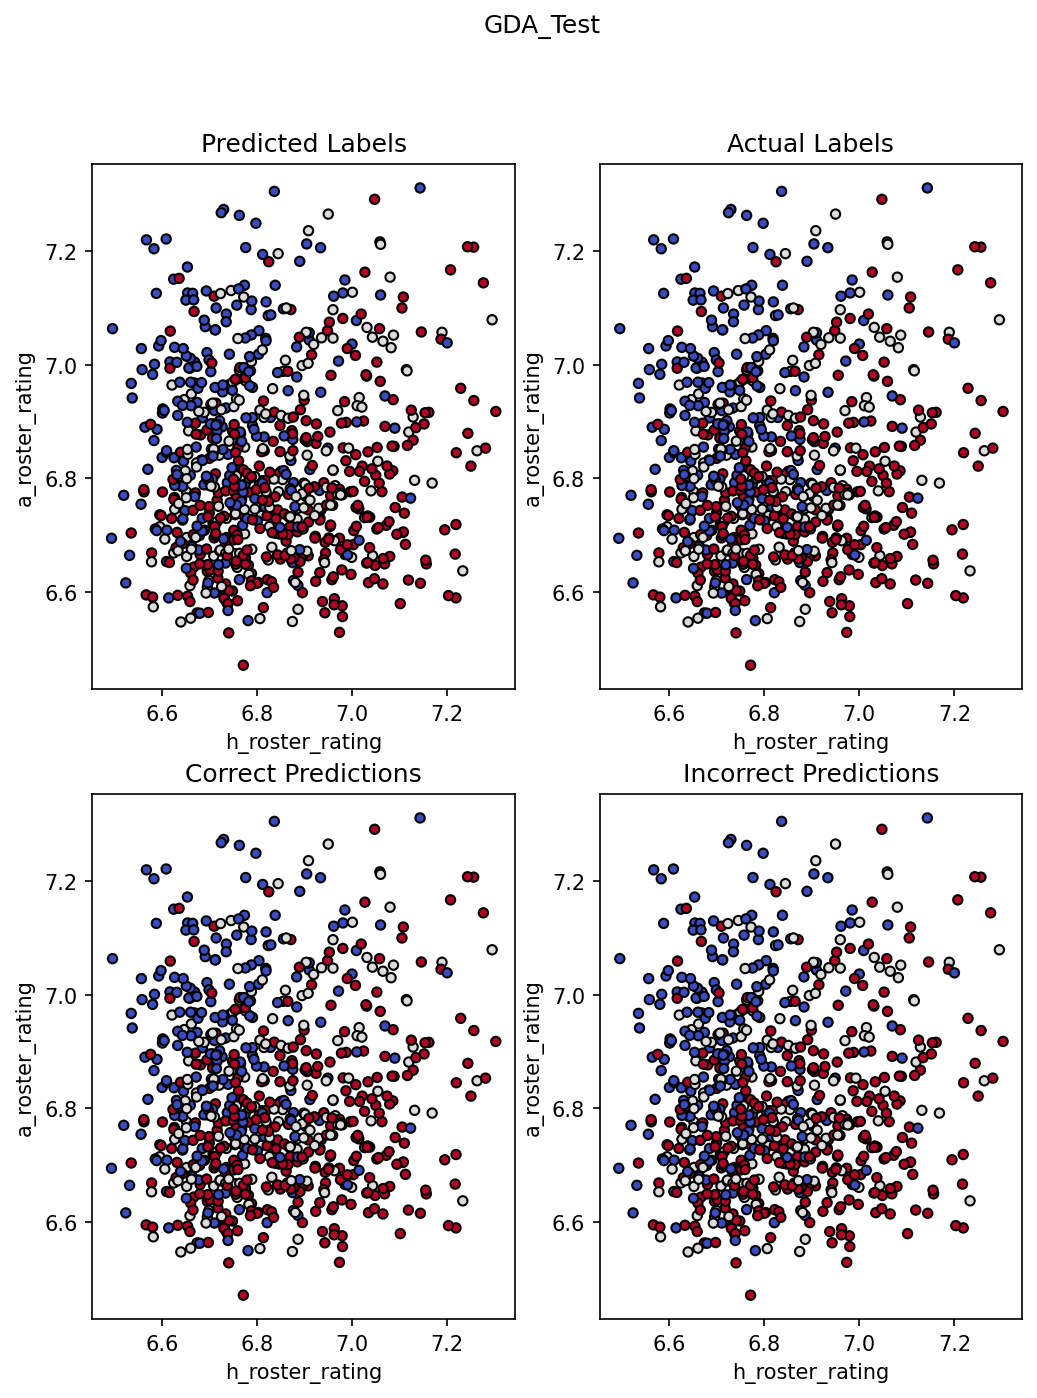

LINEAR Accuracy: 0.580


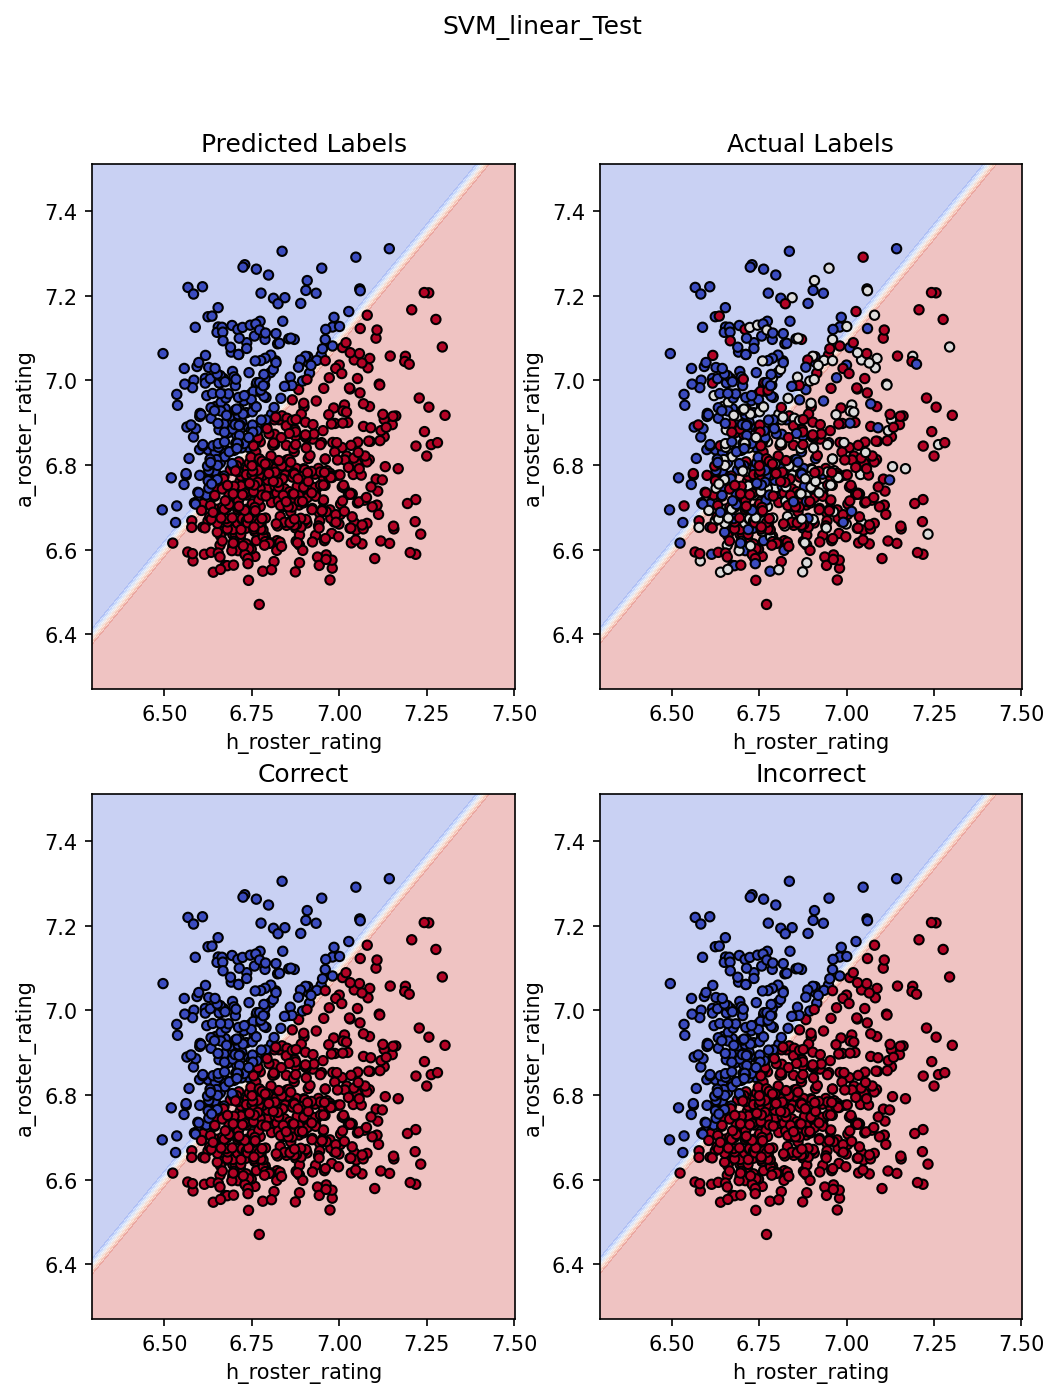

RBF Accuracy: 0.584


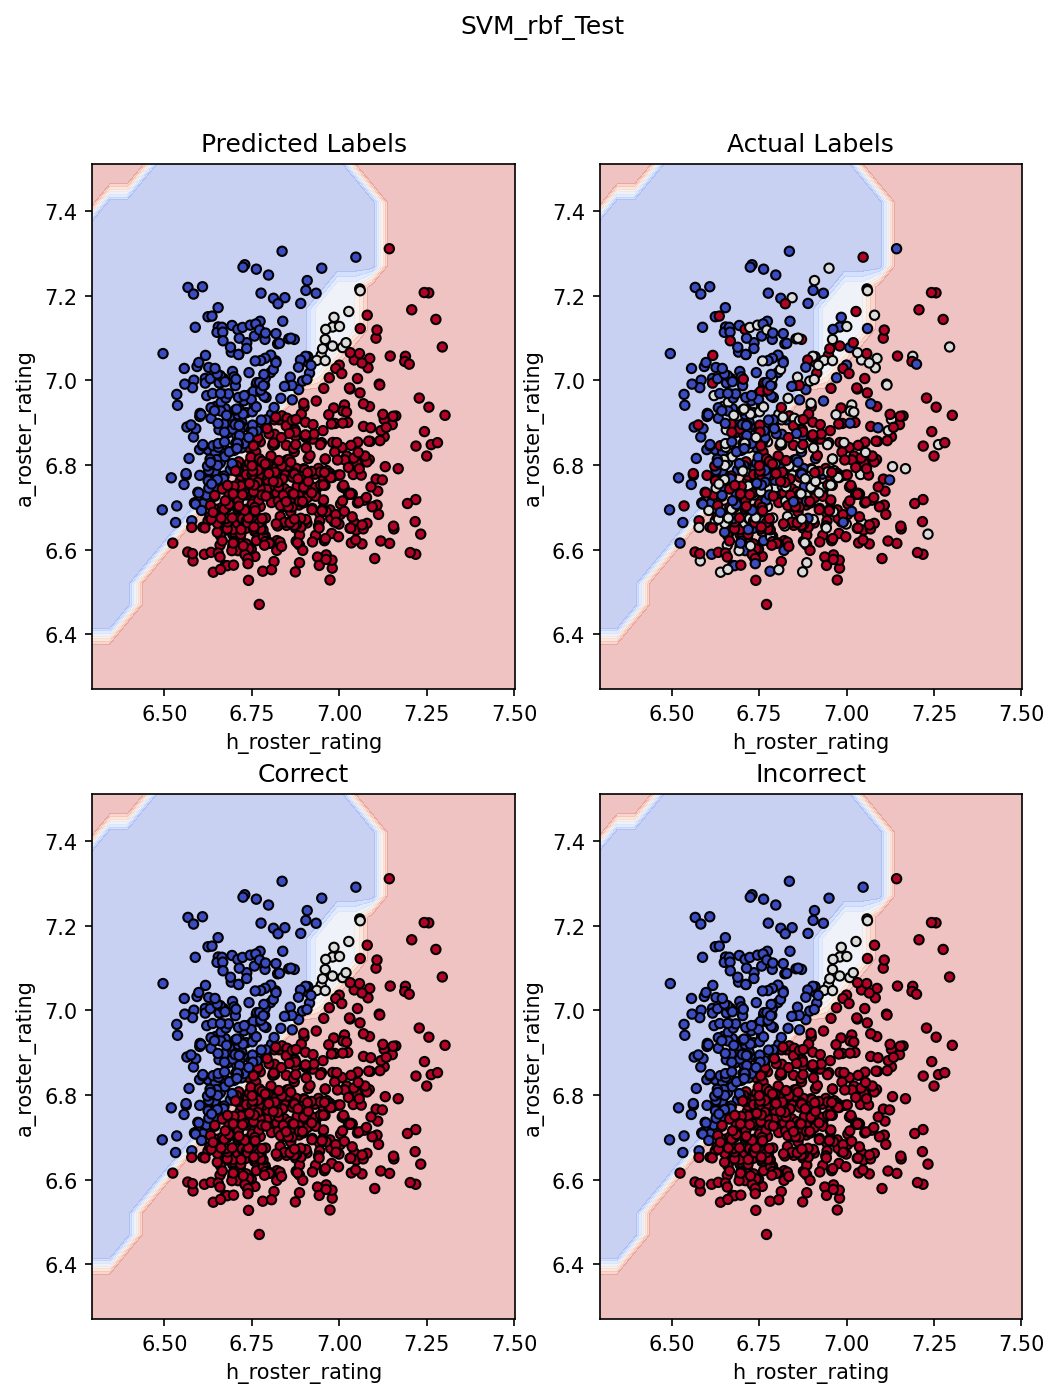

POLY Accuracy: 0.588


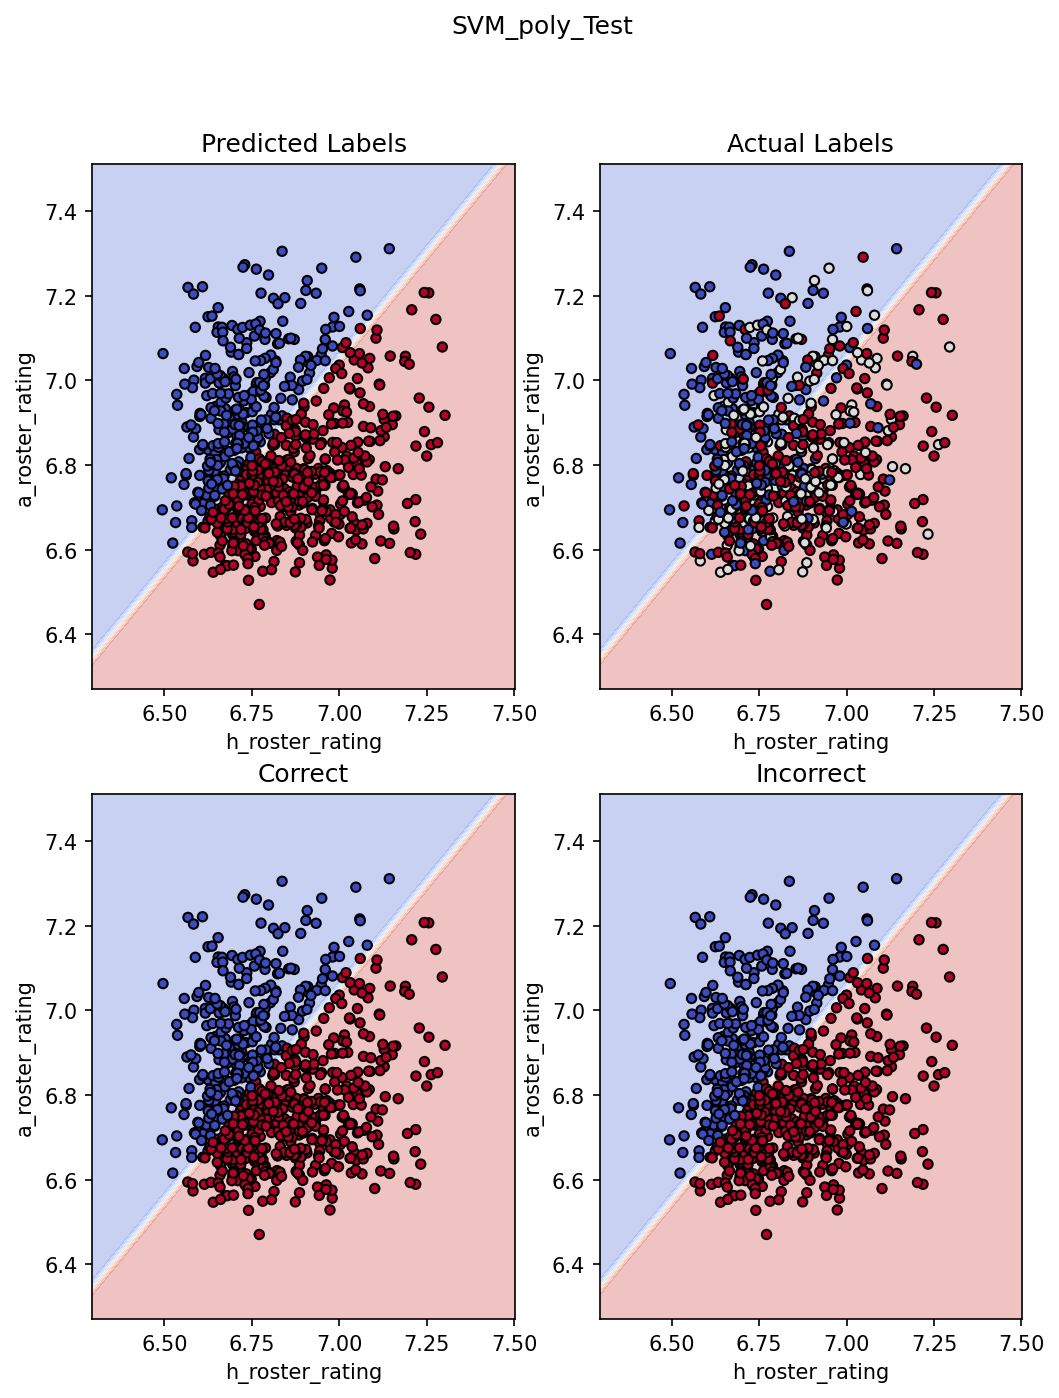

In [6]:
if __name__ == '__main__':
    shuffled_data_name = main_dir + 'match_vectors_no_label_shuffled.csv'
    L_feature = [0, 5]

    (x_train, y_train, x_test, y_test, *_,
     x_train_gaussian, y_train_gaussian,
     x_test_gaussian, y_test_gaussian) = arrange_data(shuffled_data_name, L_feature)

    d_feature = {L_feature[i]: i for i in range(len(L_feature))}

    plot_GDA(L_feature[0], L_feature[1], x_test, y_test, x_train, y_train, d_feature, 'GDA_Test')

    for kernel in ['linear', 'rbf', 'poly']:
        plot_SVM(L_feature[0], L_feature[1], kernel, x_test, y_test, x_train, y_train, d_feature,
                 n_poly=3 if kernel == 'poly' else 0, title=f"SVM_{kernel}_Test")
